# Real Estate Price prediction in Bengaluru,India

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)

## Understanding Data

In [2]:
#Reading csv file into pandas dataframe
df = pd.read_csv("C:/Users/General Use/Downloads/Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
#To see total number of rows & columns in the dataframe
df.shape

(13320, 9)

In [4]:
#Understanding how many lines of data is available based on the different area-types  column
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

## Data Cleaning 

In [5]:
#Dropping few unwanted columns which are not required for the analysis
df1=df.drop(['area_type','society','availability','balcony'],axis='columns')
df1.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


Now, my new data set has only columns of location, size, total sqft, number of bathromms & price

In [6]:
#Looking at the null values in the dataset to clean the data
df1.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [7]:
#Since we have lot of missing vales, we need to clean the dataset by either dropping the rows which has null values/by replacing the null vales with median of them
#Replacing the null values in bath column with median value
average_bath = df1['bath'].median()
df1['bath'].fillna(average_bath,inplace=True)
df1.isnull().sum()

location       1
size          16
total_sqft     0
bath           0
price          0
dtype: int64

In [8]:
#Dropping the remaining null values in location & Size as it is a very small number compared to the size of the datset
df1=df1.dropna()
df1


,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00
...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453,4.0,231.00
13316,Richards Town,4 BHK,3600,5.0,400.00
13317,Raja Rajeshwari Nagar,2 BHK,1141,2.0,60.00
13318,Padmanabhanagar,4 BHK,4689,4.0,488.00


In [9]:
#Checking for missing values to confirm
df1.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

Now, we have a clean dataset without any missing values

In [10]:
#Further exploring the dataset. Looking at the size column
df1['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

We can see that representation of same number of bedrooms is different in different rows. For example, 6 BHK & 6 Bedroom is same.
To tackle this issue, lets create a new column where we just give the number for the bedrooms

In [11]:
#Taking only the number of bedrooms by spiltting the data with space and using the 1st index
df1['bedroom']=df1['size'].apply(lambda x: int(x.split(' ')[0]))

In [12]:
df1.head()

,location,size,total_sqft,bath,price,bedroom
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


Now we have a new column added to our dataframe bedroom

In [13]:
df1['bedroom'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

Now we have cleaned the bedrooms column. Let's take a look at total_sqft column

In [14]:
df1['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

Here in the total_sqft column section, we have ranges instead of a single number. Lets clean this column.

In [15]:
#Creating a function to check if the number is float or not using try and except block. 
#ALl the ranges will come under except and lets take the average value of the range for each row
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [16]:
#These are the rows where we have a proper number instead of a range
df1[df1['total_sqft'].apply(is_float)]

,location,size,total_sqft,bath,price,bedroom
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453,4.0,231.00,5
13316,Richards Town,4 BHK,3600,5.0,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141,2.0,60.00,2
13318,Padmanabhanagar,4 BHK,4689,4.0,488.00,4


In [17]:
#These are the rows where we have a range
df1[~df1['total_sqft'].apply(is_float)]

,location,size,total_sqft,bath,price,bedroom
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
56,Devanahalli,4 Bedroom,3010 - 3410,2.0,192.000,4
81,Hennur Road,4 Bedroom,2957 - 3450,2.0,224.500,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
...,...,...,...,...,...,...
12990,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000,3
13059,Harlur,2 BHK,1200 - 1470,2.0,72.760,2
13240,Devanahalli,1 BHK,1020 - 1130,2.0,52.570,1
13265,Hoodi,2 BHK,1133 - 1384,2.0,59.135,2


In [18]:
#Let's define a function to calculate the average of the two values using split function and replace the range with average value for all the rows
def range_num(x):
    value = x.split('-')
    if len(value)==2:
        return (float(value[0])+float(value[1])/2)
    try:
        return float(x)
    except:
        return None

In [19]:
df2 =df1.copy()
df2['total_sqft']=df2['total_sqft'].apply(range_num)
df2

,location,size,total_sqft,bath,price,bedroom
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5
13316,Richards Town,4 BHK,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4


NOw the datset is cleaned and ready for our model building

## Feature Engineering

In [20]:
df3=df2.copy()
df3

,location,size,total_sqft,bath,price,bedroom
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5
13316,Richards Town,4 BHK,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4


In [21]:
#Creating a new feature price per sqft which will help in outlier detection
df3['price_per_sqft']=df3['price']*100000/df3['total_sqft']
df3.head()


,location,size,total_sqft,bath,price,bedroom,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [22]:
len(df3.location.unique())

1304

We have too many unique locations and need to sort this

In [23]:
#removing any extra spaces in the location column
df3['location'] =df3['location'].apply(lambda x: x.strip())

In [24]:
# Now looking at number of rows each location has in descending order
location_stats = df3.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               540
Sarjapur  Road           397
Electronic City          304
Kanakpura Road           273
Thanisandra              237
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [25]:
#looking at the location where datapoints is less than 10
len(location_stats[location_stats<10])

1039

In [26]:
location_stats_lessthan_10 =location_stats[location_stats<=10]

In [27]:
#lets section all these locations in OTHER category
df3.location =df3.location.apply(lambda x: 'other' if x in location_stats_lessthan_10 else x)
len(df3.location.unique())

242

In [28]:
df3

,location,size,total_sqft,bath,price,bedroom,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,other,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


## Outlier Detection

In [29]:
#let's remove row which are outliers. For example assuming the average bedroom is 300 sqft removing outliers based on this rule
df4=df3[~((df3.total_sqft/df3.bedroom)<300)]
df4

,location,size,total_sqft,bath,price,bedroom,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,other,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


Now we have only 12559 rows after removing the rows where average bedroom is not 300 sqft

Lets explore other columns also for outliers and exclude them

In [30]:
df4['price_per_sqft'].describe()

count     12513.000000
mean       6282.070788
std        4169.463545
min         267.829813
25%        4181.818182
50%        5274.725275
75%        6896.551724
max      176470.588235
Name: price_per_sqft, dtype: float64

The price per sqft varies based on the location and we just cant remove any rows which have extreme values. 

So Lets find out mean & standard deviation per location and extract rows beyond one standard deviation as the normal distribution will always have values between mean & 1.

In [31]:
def remove_outliers(df):
    df_out = pd.DataFrame()
    for key,subdf in df.groupby('location'):
        mean = np.mean(subdf.price_per_sqft)
        sd=np.std(subdf.price_per_sqft)
        reduced_df=subdf[(subdf.price_per_sqft>(mean-sd))& (subdf.price_per_sqft<(mean+sd))]
        df_out=pd.concat([df_out,reduced_df], ignore_index=True)
    return df_out

In [32]:
df5=remove_outliers(df4)
df5

,location,size,total_sqft,bath,price,bedroom,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.00,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.00,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.00,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.00,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.00,2,11983.805668
...,...,...,...,...,...,...,...
10263,other,2 BHK,1353.0,2.0,110.00,2,8130.081301
10264,other,1 Bedroom,812.0,1.0,26.00,1,3201.970443
10265,other,3 BHK,1440.0,2.0,63.93,3,4439.583333
10266,other,2 BHK,1075.0,2.0,48.00,2,4465.116279


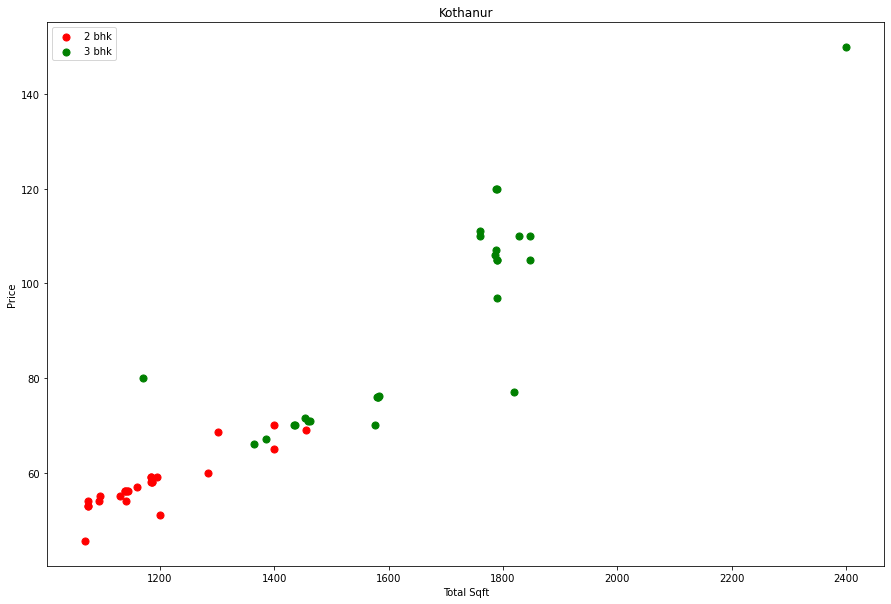

In [33]:
#Looking at the price comparision between 2 bedroom and 3 bedroom
def scatter_plot(df,location):
    bhk2 = df[(df.location==location)& (df.bedroom ==2)] 
    bhk3 = df[(df.location==location)& (df.bedroom ==3)]
    matplotlib.rcParams['figure.figsize']=(15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color ='red',label='2 bhk',s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,color='green',label='3 bhk', s=50)
    plt.xlabel('Total Sqft')
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()
    
scatter_plot(df5,'Kothanur')

In the above plot, we can see there are couple of outliers near 1400 sqft

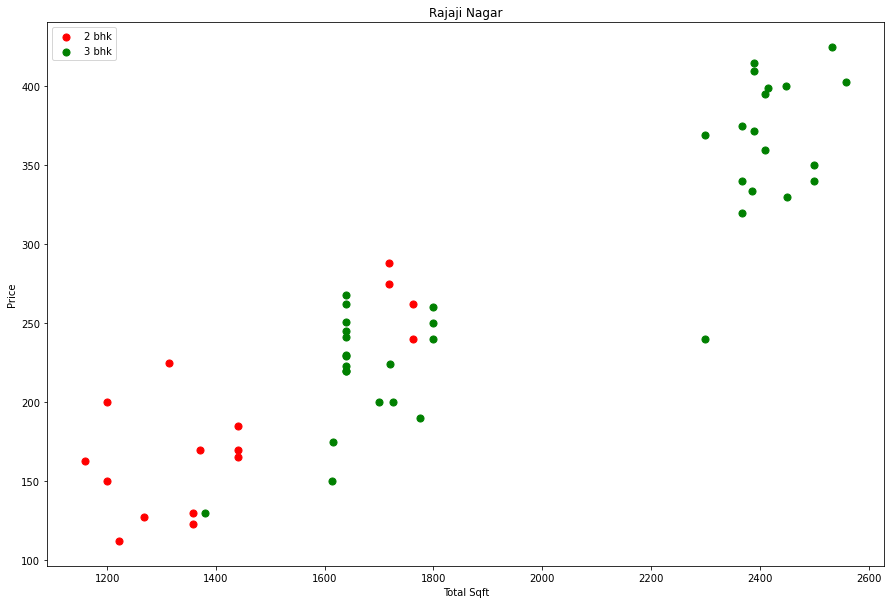

In [34]:
scatter_plot(df5,"Rajaji Nagar")

Even in Rajaji Nagar, we have couple of outliers near 1700, 1400 sqft where 3 bhk prices are less than or equal to 2bhk

Removing bhk prices which are less than smaller bhk's

In [35]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bedroom'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bedroom'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df6 = remove_bhk_outliers(df5)
df6

,location,size,total_sqft,bath,price,bedroom,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
...,...,...,...,...,...,...,...
10259,other,2 BHK,1200.0,2.0,70.0,2,5833.333333
10260,other,1 BHK,1800.0,1.0,200.0,1,11111.111111
10263,other,2 BHK,1353.0,2.0,110.0,2,8130.081301
10264,other,1 Bedroom,812.0,1.0,26.0,1,3201.970443


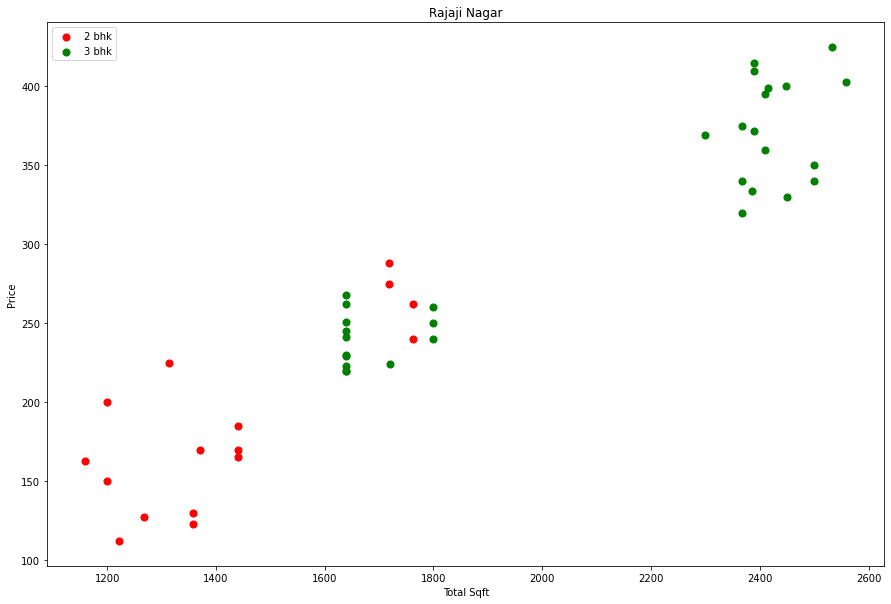

In [36]:
#Observing the Rajai Nagar area after removing 3 bedrooms which are lesser than 2 bedroom
scatter_plot(df6,"Rajaji Nagar")

Text(0, 0.5, 'Count')

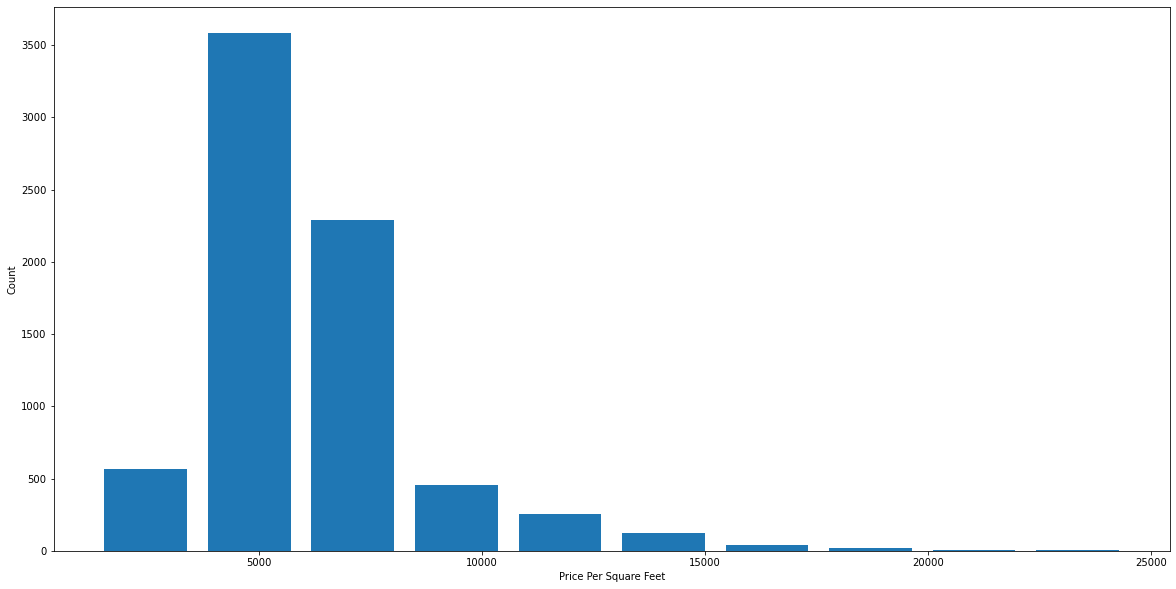

In [37]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df6.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

Most of the houses are in the range of 0-10,000 ruppees per sqft

Looking at the number of bathrooms column to check for outliers and remove if any

In [38]:
df6['bath'].unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

we have more than 10 bathrooms in the data set which is very unlikely.

In [39]:
df6[df6['bath']>10]

,location,size,total_sqft,bath,price,bedroom,price_per_sqft
5299,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8512,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8601,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9334,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9665,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


we have very less number compared to the size of the dataset. 

Let's exclude the data points where number of bathrooms are more than mnumber of bedrooms+2--> Considering this rule as it is very unlikely to have more number of bathrooms than bedrooms

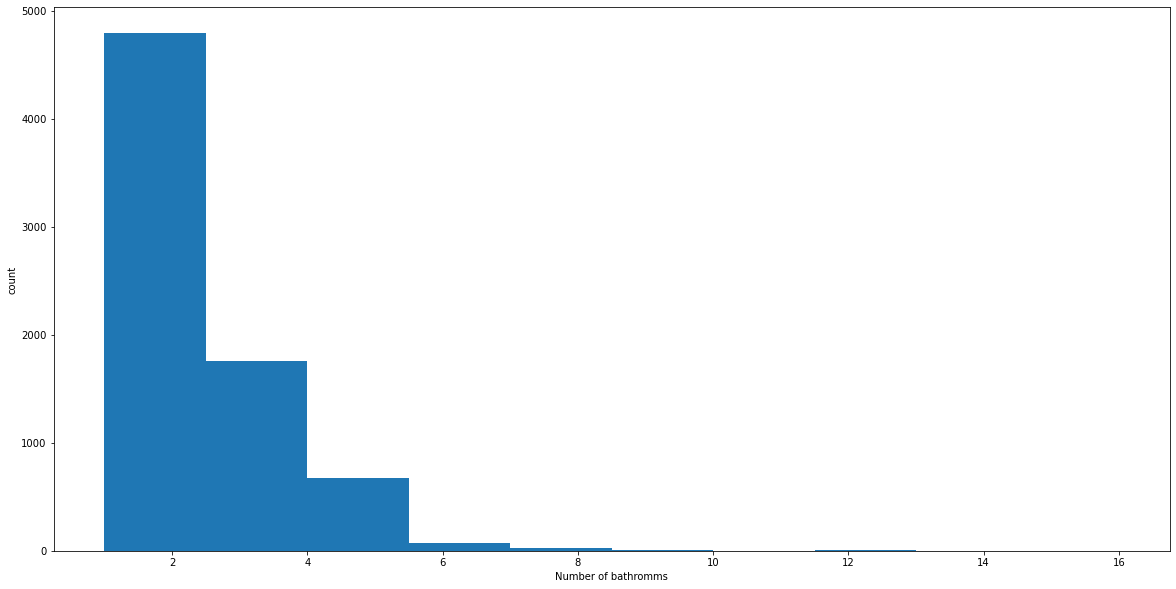

In [40]:
plt.hist(df6.bath)
plt.xlabel('Number of bathromms')
plt.ylabel("count")
plt.show()

In [41]:
df6[df6['bath']>(df6['bedroom']+2)]

,location,size,total_sqft,bath,price,bedroom,price_per_sqft
1629,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5260,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6739,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8437,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


Let's remove all the outliers where number of bathrooms> number of bedrooms+2

In [42]:
#Taking the datapoints excluding the above 4 which are outliers
df7=df6[df6['bath']<(df6['bedroom']+2)]
df7

,location,size,total_sqft,bath,price,bedroom,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
...,...,...,...,...,...,...,...
10259,other,2 BHK,1200.0,2.0,70.0,2,5833.333333
10260,other,1 BHK,1800.0,1.0,200.0,1,11111.111111
10263,other,2 BHK,1353.0,2.0,110.0,2,8130.081301
10264,other,1 Bedroom,812.0,1.0,26.0,1,3201.970443


In [43]:
df8=df7.drop(['size','price_per_sqft'],axis='columns')
df8

,location,total_sqft,bath,price,bedroom
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2
...,...,...,...,...,...
10259,other,1200.0,2.0,70.0,2
10260,other,1800.0,1.0,200.0,1
10263,other,1353.0,2.0,110.0,2
10264,other,812.0,1.0,26.0,1


## Building a Machine Learning model and choosing the best fit algorithm for the dataset

In [44]:
#Lets use one hot encoding technique to convert the data into 0's & 1's as ML models do not understand text data
df9= pd.get_dummies(df8.location)
df9.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df10=pd.concat([df8,df9.drop('other', axis='columns')], axis='columns')
df10

,location,total_sqft,bath,price,bedroom,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10259,other,1200.0,2.0,70.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10260,other,1800.0,1.0,200.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10263,other,1353.0,2.0,110.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10264,other,812.0,1.0,26.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df11=df10.drop('location',axis='columns')
df11

,total_sqft,bath,price,bedroom,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10259,1200.0,2.0,70.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10260,1800.0,1.0,200.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10263,1353.0,2.0,110.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10264,812.0,1.0,26.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
#Segregating dependent & independent columns/data to train and test our model
x=df11.drop('price',axis='columns')
x

,total_sqft,bath,bedroom,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10259,1200.0,2.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10260,1800.0,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10263,1353.0,2.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10264,812.0,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
y=df11['price']
y

0        428.0
1        194.0
2        235.0
3        130.0
4        148.0
         ...  
10259     70.0
10260    200.0
10263    110.0
10264     26.0
10267    400.0
Name: price, Length: 7265, dtype: float64

In [49]:
#Training the model by train_test_split from sklearn
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test= train_test_split(x,y,test_size=0.2, train_size=0.8,random_state=10)

In [50]:
#Building a Linear Regression Model for the datset and checking its accuracy
from sklearn.linear_model import LinearRegression
Linear_reg=LinearRegression()
Linear_reg.fit(x_train,y_train)
Linear_reg.score(x_test, y_test)

0.8023094810712414

The Score is 80% success rate for using Linear Regression Model

Uisng K-fold Cross validation technique (average of different iterations of multiple buckets of train & test data) to measure accuracy of Linear Regression model

In [51]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
crossvalidation =ShuffleSplit(n_splits=5, test_size=0.2,random_state=0)
cross_val_score(LinearRegression(), x,y, cv= crossvalidation)



array([0.8280185 , 0.87166904, 0.85859967, 0.85046902, 0.8065565 ])

We can see that average accuracy of using Linear Regression Model is above 80%.

In [56]:
#Using Grid Search CV to check if other alogorithms provides more accuracy
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def best_model(x,y):
    algos={
        'Linear Regression':{
            'model':LinearRegression(),
            'params':{
                'normalize':[True,False]
            }
        },
        'Lasso':{
            'model':Lasso(),
            'params':{
                'alpha':[1,2],
                'selection':['random','cyclic']
            }
        },
        'DecisionTree':{
            'model':DecisionTreeRegressor(),
            'params':{
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
       
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

best_model(x,y)

,model,best_score,best_params
0,Linear Regression,0.843063,{'normalize': False}
1,Lasso,0.702319,"{'alpha': 1, 'selection': 'cyclic'}"
2,DecisionTree,0.744470,"{'criterion': 'mse', 'splitter': 'random'}"


By the above results, we can say that our Linear Regression model provides higher accuracy of 84% compared to Lasso & Decision Tree Algorithms.